## 2. Neural Network Classification with PyTorch

# 1. Make classification data and get it ready.


In [464]:
from sklearn.datasets import make_circles
# make 1000 samples
n_samples = 1000

# create circles.
X,y = make_circles(n_samples,
                   noise=0.03, random_state=42)

In [465]:
len(X),len(y)

(1000, 1000)

In [466]:
# Printing first few samples.
print(f"First 5 smaples of X : \n {X[:5]}")
print(f"First 5 samples of y : \n {y[:5]}")

First 5 smaples of X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y : 
 [1 1 1 1 0]


Assigning Names to the columns of the X-matrix

In [467]:
# Make dataframes of circles data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2":X[:,1],
                        "label": y})

In [355]:
circles.head(4)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1


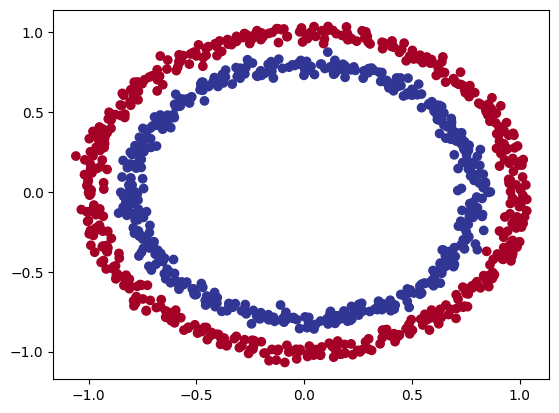

In [356]:
# visualize, visualize, visualize
import matplotlib.pyplot as plt
# plotting both the columns of X.
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)

1.1 Check input and output shapes.

In [468]:
X.shape, y.shape
# y is just a scalar.

((1000, 2), (1000,))

In [469]:
# view the first sample of features and labels.
print(X[0] )
print(y[0])

[0.75424625 0.23148074]
1


In [359]:
# Turn data into tensors and create test train split.
import torch
torch.__version__

'2.0.1+cu118'

In [470]:
type(X),X.dtype

(numpy.ndarray, dtype('float64'))

In [471]:
# Turn data into tensors.
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [472]:
# Train test split.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [473]:
len(X_test),len(X_train)

(200, 800)

## 2. Building a model.
Let's Build a model to classify our blue and red dots.
To do so, we want to:
1. Setup Device agnostic code.
2. Construct model(subclassing nn.Module)
3. Define loss and optimizer
4. Creating train and test loop

In [364]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## let's create our model
1. subclasses `nn.Module`: almost all models in pytorch subclass `nn.Module`.
2. Create `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model.
4. Instantiate an instance of our model class and send it to the target device.

In [474]:
X_train.shape
# 2 input features.

torch.Size([800, 2])

In [475]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer1 = nn.Linear(in_features=2,out_features=5) # 2 x 5
    self.linear_layer2 = nn.Linear(in_features=5,out_features=1) # 5 x 1

  # forward computation
  def forward(self,x):
    return self.linear_layer2(self.linear_layer1(x)) # x->layer1 -> layer2 ->output



In [476]:
# Instantiate an instance of our model send it to the target device.
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (linear_layer1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [368]:
device
# model parameters are on gpu.


'cpu'

# let's replicate the model using `nn.Sequential()`

In [477]:
# this will overwrite the model and it will from Sequntial and not our custom subclass.
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.Linear(in_features = 5, out_features =1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [478]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4365, -0.2268],
                      [-0.5187, -0.1248],
                      [-0.3428, -0.2163],
                      [-0.6732,  0.3956],
                      [-0.4923,  0.3554]])),
             ('0.bias', tensor([ 0.3209,  0.5052, -0.5424,  0.5085, -0.3343])),
             ('1.weight',
              tensor([[ 0.1659,  0.4200, -0.0631, -0.0035, -0.1030]])),
             ('1.bias', tensor([-0.3734]))])

In [479]:
# Make predictions
with torch.inference_mode():
   untrained_preds =model_0(X_test.to(device))
print(f"Lenght of predictions: {len(untrained_preds)}, shape:{untrained_preds.shape}")


Lenght of predictions: 200, shape:torch.Size([200, 1])


In [480]:
untrained_preds[:4]

tensor([[-0.0926],
        [-0.1520],
        [ 0.0446],
        [-0.1315]])

# 2.1 Setup the loss function and optimizer.

In [481]:
# loss_fn = nn.BCELoss() # BCELoss  requires input to have gone through the sigmoid activation function prior to the input to BCELoss.
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in: provide more numeric statbility

optimizer = torch.optim.SGD(params = model_0.parameters(),lr=0.1)

In [482]:
# Calculate the accuracy of the model:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() # sum of all the equal predictions.
  acc = (correct/len(y_pred))*100
  return acc


# Training the model

 **Logits** -> **predction prob** (sigmoid)  -> **prediction label** (0.5 rounding)

## 3.1 Going from raw logits --> prediction probabilities --> prediction lables.
Out Model outputs are going to be raw logits.
We can convert these logits into **prediction probabilities** by passing them to some kind of activation function
(sigmoid for binary and **softmax** for multiclass classfication).
Then we can convert our model's prediction probabilities to prediction lables by either rounding them or taking the `argmax()`.

In [483]:
# View first 5 outputs of the forward pass on the test data.
# evaluation mode and inference mode ON:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0926],
        [-0.1520],
        [ 0.0446],
        [-0.1315],
        [ 0.0154]])

In [376]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5620],
        [0.5639],
        [0.5416],
        [0.5678],
        [0.5173]])

# For our prediction probabilities values, we need to perform a range-style rounding on them.

`y_pred_probs >= 0.5 --> y = 1 (class = 1)`

` = 0, otherwise`

In [377]:
# Find the predicted labels.
y_preds = torch.round(y_pred_probs)

# In full (logits-> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality:
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

# Building a training and testing loop

In [378]:
# Unofficial PyTorch Optimization song: Remember !!!!!!!!
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100
# on target device.
X_train, y_train = X_train.to(device),y_train.to(device)
X_test, y_test  = X_test.to(device), y_test.to(device)


# Training loop
for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass: y_logtis -> sigmoid(y_logit) -> round(sigmoid)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turns logits->pred probs -> pred labels.

  # 2. Loss / accuracy:
  ## loss function is BCEWithLogitsLoss() : takes logits as input
  ## Earlier for BCELoss() we provided y_pred directly.
  loss = loss_fn(y_logits,y_train)
  #### Already Declared above
  acc = accuracy_fn(y_true=y_train,y_pred = y_pred)

  # 3. 0 grad.
  optimizer.zero_grad()
  # 4. back back.
  loss.backward()
  # 5. step step
  optimizer.step()

  ## Testing:
  model_0.eval()
  with torch.inference_mode():
    # forward pass : with logits , sigmoid, pred lables.
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # loss/ accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # Printing what's happening:
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}z%")

Epoch: 0 | Loss: 0.69662 | Acc: 50.00% | Test loss: 0.69839 | Test Acc: 50.00z%
Epoch: 10 | Loss: 0.69394 | Acc: 58.38% | Test loss: 0.69599 | Test Acc: 58.00z%
Epoch: 20 | Loss: 0.69325 | Acc: 52.75% | Test loss: 0.69533 | Test Acc: 50.50z%
Epoch: 30 | Loss: 0.69307 | Acc: 51.88% | Test loss: 0.69513 | Test Acc: 49.00z%
Epoch: 40 | Loss: 0.69302 | Acc: 51.38% | Test loss: 0.69503 | Test Acc: 46.00z%
Epoch: 50 | Loss: 0.69300 | Acc: 51.25% | Test loss: 0.69498 | Test Acc: 47.00z%
Epoch: 60 | Loss: 0.69299 | Acc: 51.38% | Test loss: 0.69494 | Test Acc: 47.50z%
Epoch: 70 | Loss: 0.69299 | Acc: 51.12% | Test loss: 0.69491 | Test Acc: 47.00z%
Epoch: 80 | Loss: 0.69299 | Acc: 51.12% | Test loss: 0.69488 | Test Acc: 47.00z%
Epoch: 90 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69486 | Test Acc: 46.50z%


## Here, we are getting accuracy of 50%. Means our model is just making some **random guesses**.

In [379]:
circles.label.value_counts()
# balanced data.
# Same as getting head/tail prediction.

1    500
0    500
Name: label, dtype: int64

## 4. Make prediction and evaluate the model.
So to inspect it let's make some prediction
visualize visualize !!!!
TO do so, we're going to import a function `plot_decision_boundary()`

In [380]:
import requests
from pathlib import Path
# Download helper function from learn pytorch repo(if not downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exist


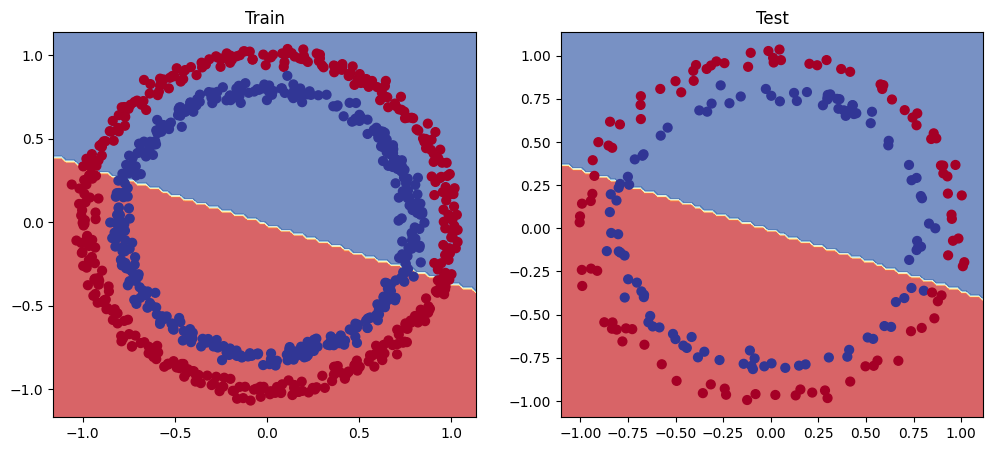

In [381]:
# Plot decision boundary of the model.
#Training data.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)

#Testing data
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [484]:
# So our model is basically fitting a linear line on non-linear data.
# so we got less accuracy earlier.

## Improving a model(from a model perspective)
* Add more layer--> give the model more chance to learn about the pattern in the data.
* Add more hidden units - to from 5 hidden units to 10 hidden units.
* Fit for longer --> give more chance to learn.
* Changing the activation functions.
* Changing the learning rate
* Change the loss functions.

These options are from model's perspective since they deal directly with the model, rather than the data.

And because these options are all values we can change, they are referred as **Hyperparameters**

In [383]:
X_train.shape

torch.Size([800, 2])

In [485]:
# Let's change the hyperparameters.
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # leverages speed ups than previous

In [385]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [486]:
# loss_fn = nn.BCELoss() # BCELoss  requires input to have gone through the sigmoid activation function prior to the input to BCELoss.
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in: provide more numeric statbility

optimizer = torch.optim.SGD(params = model_0.parameters(),lr=0.1)

In [387]:
# Unofficial PyTorch Optimization song: Remember !!!!!!!!
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100
# on target device.
X_train, y_train = X_train.to(device),y_train.to(device)
X_test, y_test  = X_test.to(device), y_test.to(device)


# Training loop
for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass: y_logtis -> sigmoid(y_logit) -> round(sigmoid)
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turns logits->pred probs -> pred labels.

  # 2. Loss / accuracy:
  ## loss function is BCEWithLogitsLoss() : takes logits as input
  ## Earlier for BCELoss() we provided y_pred directly.
  loss = loss_fn(y_logits,y_train)
  #### Already Declared above
  acc = accuracy_fn(y_true=y_train,y_pred = y_pred)

  # 3. 0 grad.
  optimizer.zero_grad()
  # 4. back back.
  loss.backward()
  # 5. step step
  optimizer.step()

  ## Testing:
  model_1.eval()
  with torch.inference_mode():
    # forward pass : with logits , sigmoid, pred lables.
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # loss/ accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # Printing what's happening:
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 10 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 20 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 30 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 40 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 50 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 60 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 70 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 80 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%
Epoch: 90 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test Acc: 51.00%


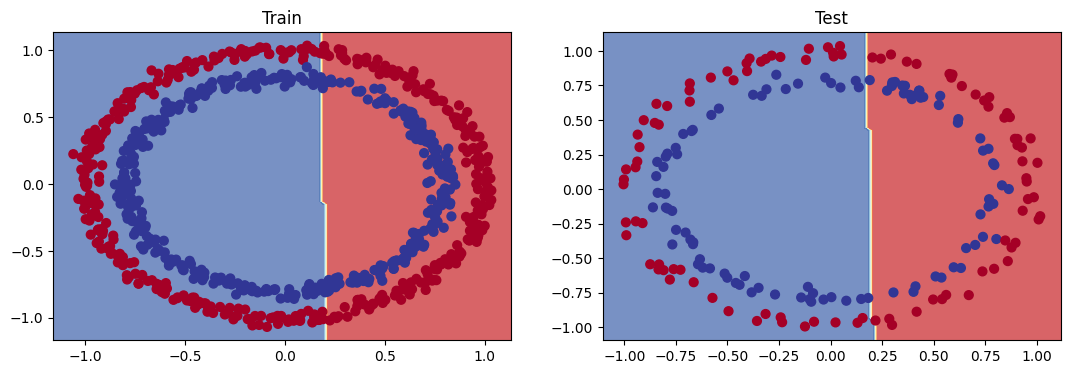

In [388]:
# Plot the decision boundary.
# Training data.
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)

# Testing data.
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)


In [389]:
## Althought the number of epochs = 1000, our model is not learning anything just making random guesses (50% accuracy.)

## Preparing data to see if our model can fit a straight line
One way to troubleshoot this is to test out a smaller problem.

In [390]:
# Create some data (same as last notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias #  Linear Reg formula.

# Check the data.
print(len(X_regression))
X_regression[:5],y_regression[:5] # first 5 data

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [391]:
# create train and test splits
train_split = int(0.8*len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split],y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:],y_regression[train_split:]

# checking the lengths of each
len(X_train_reg),len(X_test_reg)

(80, 20)

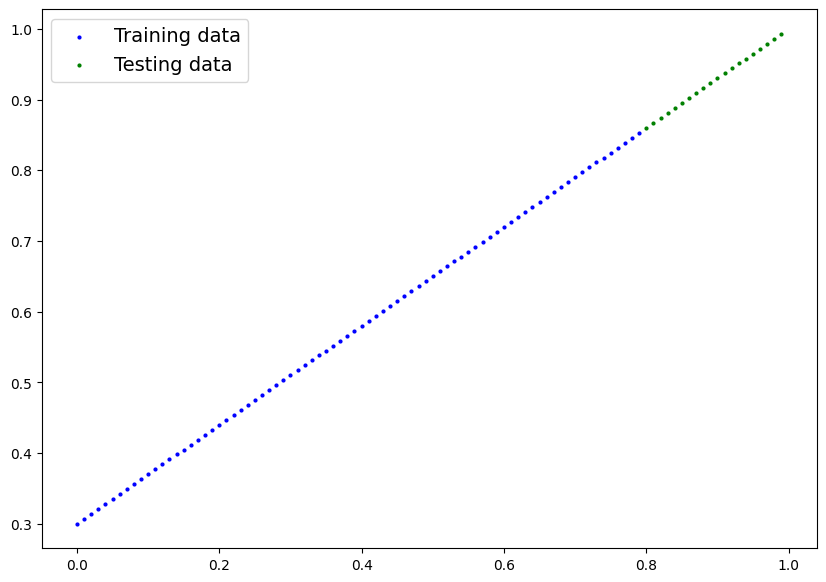

In [392]:
# Plot prediction
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

In [393]:
# our linear regression model is taking one features and giving one output feature.
# But the data we are working on is having 2 input features and one output feature.

## Adjusting `model_1` to fit a straigt line

In [394]:
# Same architecture as model_1(but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [395]:
# LOss and optimizer.
loss_fn = nn.L1Loss() # MEAN ABS ERROR.
optimizer = torch.optim.SGD(params = model_2.parameters(),lr=0.1)

# Train the model

In [396]:
# manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# No of epochs
epochs = 1000

# put the data on same device
X_train_reg = X_train_reg.to(device)
y_train_reg = y_train_reg.to(device)
X_test_reg = X_test_reg.to(device)
y_test_reg = y_test_reg.to(device)

# Training loop song.
for epoch in range(epochs):
  model_2.train()
  # Forward pass.
  y_pred = model_2(X_train_reg)
  # Loss
  loss = loss_fn(y_pred,y_train_reg)
  # zero grad
  optimizer.zero_grad()
  # backward.
  loss.backward()
  # step step
  optimizer.step()

  ## Testing loop
  model_2.eval()
  with torch.inference_mode():
    # forward pass
    test_pred = model_2(X_test_reg)
    # loss
    test_loss = loss_fn(test_pred,y_test_reg)

  # Printing what's happpening.
  if epoch %100 == 0:
    print(f"Epoch : {epoch} loss: {loss:.5f} || test loss: {test_loss:.4f}")

Epoch : 0 loss: 0.75986 || test loss: 0.5414
Epoch : 100 loss: 0.09309 || test loss: 0.0290
Epoch : 200 loss: 0.07376 || test loss: 0.0285
Epoch : 300 loss: 0.06745 || test loss: 0.0062
Epoch : 400 loss: 0.06107 || test loss: 0.0200
Epoch : 500 loss: 0.05698 || test loss: 0.0106
Epoch : 600 loss: 0.04857 || test loss: 0.0133
Epoch : 700 loss: 0.06109 || test loss: 0.0213
Epoch : 800 loss: 0.05600 || test loss: 0.0143
Epoch : 900 loss: 0.05571 || test loss: 0.0060


In [397]:
# loss is reducing:  model_2 is leanring something.

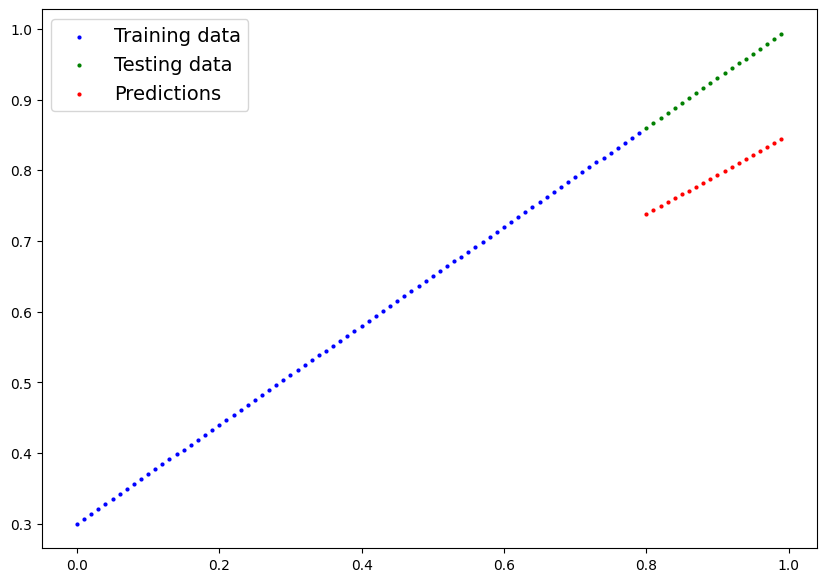

In [398]:
# plotting prediction.
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_reg)

plot_predictions(X_train_reg.cpu(),y_train_reg.cpu(),X_test_reg.cpu(),y_test_reg.cpu(),predictions=y_preds.cpu())

In [399]:
# So the model is learning something. May be the problem is with the data we are using.


## 6. The Missing piece: Non-Linearity.


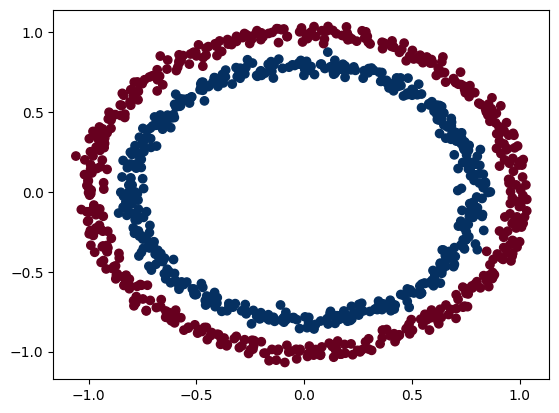

In [400]:
# Make and plot data.
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,noise=0.03,random_state=42)
plt.scatter(X[:,0],X[:,1],c = y, cmap = plt.cm.RdBu);

In [401]:
# Train test split, tensor conversion
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors.
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test sets.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train[:4],y_train[:4]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256]]),
 tensor([1., 0., 0., 0.]))

## 6.2 Building a model with non-linearity
* Linear = straight line
* Non-Linear = Non-straight line

In [402]:
# build model with non-linear activation functions.
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    # Where should we put out non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [403]:
# instantiate model
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [404]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(),lr = 0.1)

In [405]:
# random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all the data on target device.
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

# Loop through data
epochs = 1000

# Loop Song
for epoch in range(epochs):
  ## training
  model_3.train()
  # forward.
  y_logit = model_3(X_train).squeeze() # get rid of extra 1 dimension.
  y_label = torch.round(torch.sigmoid(y_logit))

  # loss
  loss = loss_fn(y_logit,y_train) # BCE with logit loss.
  acc = accuracy_fn(y_train,y_label)

  # zero grad.
  optimizer.zero_grad()
  # backward
  loss.backward()
  # step step
  optimizer.step()

  ## Testing:
  model_3.eval()
  with torch.inference_mode():
    # forward
    test_logit = model_3(X_test).squeeze()
    test_label = torch.round(torch.sigmoid(test_logit))
    # loss
    test_loss = loss_fn(test_logit,y_test)
    test_acc = accuracy_fn(test_label,y_test)

  # print what's happeing:
  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | loss: {loss:.4f} | acc: {acc:.2f}% | test loss: {test_loss:.3f} | test acc: {test_acc:.2f}%")



Epoch:0 | loss: 0.6929 | acc: 50.00% | test loss: 0.693 | test acc: 50.00%
Epoch:100 | loss: 0.6912 | acc: 52.88% | test loss: 0.691 | test acc: 52.50%
Epoch:200 | loss: 0.6898 | acc: 53.37% | test loss: 0.689 | test acc: 55.00%
Epoch:300 | loss: 0.6879 | acc: 53.00% | test loss: 0.687 | test acc: 56.00%
Epoch:400 | loss: 0.6852 | acc: 52.75% | test loss: 0.684 | test acc: 56.50%
Epoch:500 | loss: 0.6810 | acc: 52.75% | test loss: 0.679 | test acc: 56.50%
Epoch:600 | loss: 0.6751 | acc: 54.50% | test loss: 0.673 | test acc: 56.00%
Epoch:700 | loss: 0.6666 | acc: 58.38% | test loss: 0.663 | test acc: 59.00%
Epoch:800 | loss: 0.6516 | acc: 64.00% | test loss: 0.648 | test acc: 67.50%
Epoch:900 | loss: 0.6236 | acc: 74.00% | test loss: 0.621 | test acc: 79.00%


# let's Visualize !!!

In [406]:
# putting in evaluation mode.
model_3.eval()
with torch.inference_mode():
  y_logit = model_3(X_test).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logit))
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

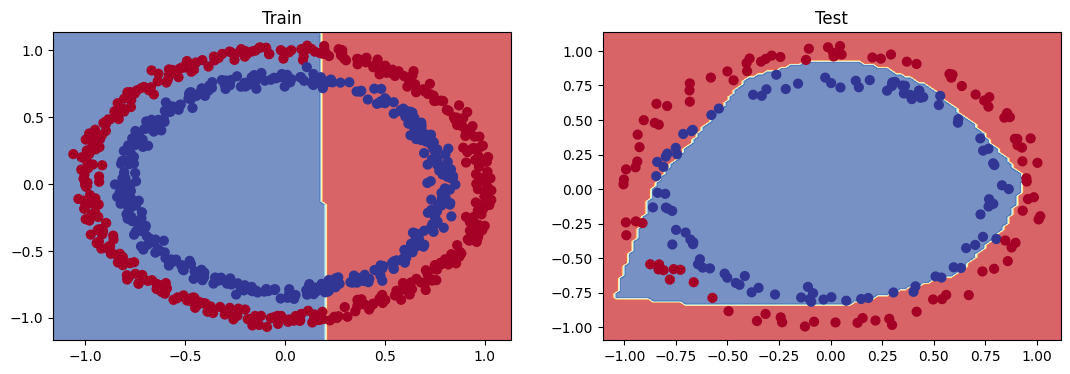

In [407]:
# Plot the decision boundary.
# Training data.
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)

# Testing data.
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)


In [408]:
# Model 1: No Non-Linearity
# Model 3: Has Non-Linearity

# WE can improve the test accuracy:
1. add more layers, hidden units, fit for longer...

# Replicating  non-linear activation functions.
Neural networks, rather than use telling the model what to learn, we give it the tool to discover patterns in the data and it learns the pattern on its own.

In [409]:
# Create a tensor
A = torch.arange(-10,10,1,dtype = torch.float32)
A.dtype

torch.float32

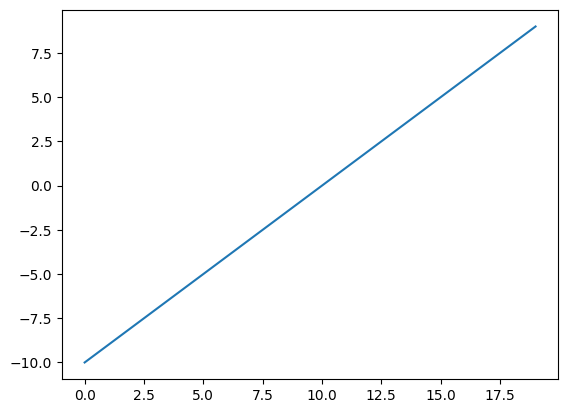

In [410]:
plt.plot(A)

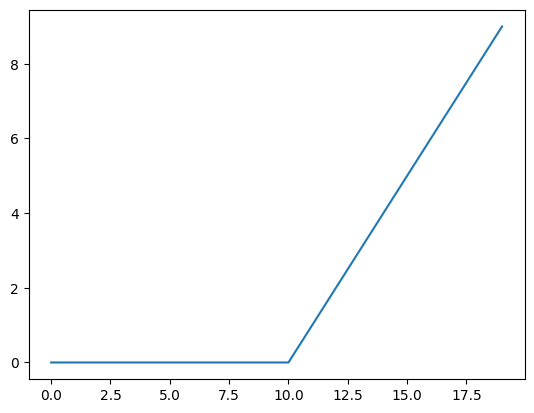

In [411]:
# relu function.
plt.plot(torch.relu(A))

In [412]:
# Writing the relu funciton.
def relu(x):
  return torch.maximum(torch.tensor(0),x) # input must be tensor.

In [413]:
relu(A)
# plt.plot(relu(A))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [414]:
# replicating the sigmoid function. | custom function.
def sigmoid(x):
  return 1/ (1+torch.exp(-x))

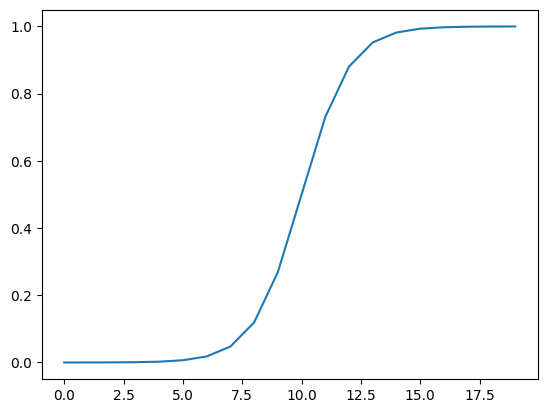

In [415]:
plt.plot(sigmoid(A))

## 8. Multi-Class classification
* Binary classifcation: cat vs dog, spam/ham
* Multi-Class:  A/B/C/....

## 8.1 Creating a toy multi-class datasets

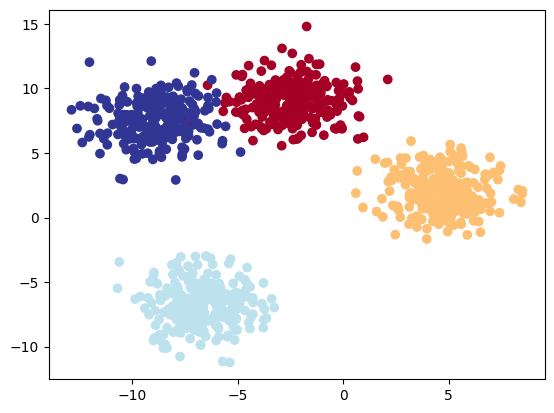

In [416]:
# importing depedencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data selection.
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED  = 42

# 1. Creating Multi-Class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features =NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std = 1.5, # give cluster little shake up
                            random_state=RANDOM_SEED)
# 2. Data to tensors.
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train test
X_blob_train, X_blob_test, y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)
# 4. PLOT( Visualize !!!)
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

# 8.2 Building a multi-class classification in PyTorch

In [417]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [418]:
# Building a mulit-class classfication model.
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """
    Summary line.

    Initialize multi-class classification model.

    Parameters:
    Args (int):
      input_features: input features of model.
      output_features: output classes.
      hidden_unit: No of hidden units b/w layers.

    Returns:
    int: Description of return value
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

In [419]:
# Creating an instance of BlobModel and send it to the target device.
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [420]:
# setting up the loss functions and optimizer
loss_fn = nn.CrossEntropyLoss() # loss function measures
optimizer = torch.optim.SGD(params=model_4.parameters(),lr = 0.1)

## 8.2 Getting prediction probabilities for a multi-class PyTorch model.

In [421]:
# get some raw output of the model(logits)
model_4.eval()
with torch.inference_mode():
  y_logits= model_4(X_blob_test.to(device))

y_logits[:3]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107]])

In [422]:
y_blob_test[:3]

tensor([1, 3, 2])

## We need ot transform the output features of model in terms of [0,1,2,3].


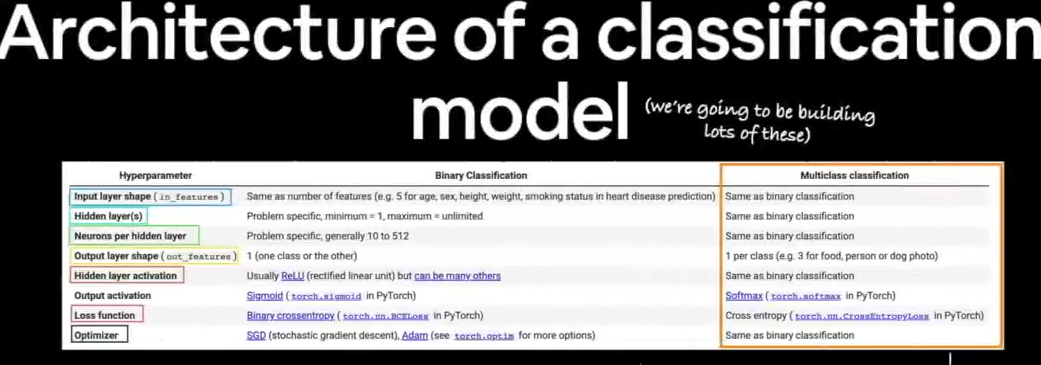

In [423]:
# Convert our model's logit output to prediction probabilities.
y_pred_probs = torch.softmax(y_logits,dim =1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


# Creating a training and testing loop for a multi-class pytorch model

In [424]:
# Fit the multi-class model to the data.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the epoch
epochs = 100

# put the data to the target device.
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

## TRaining loop
for epoch in range(epochs):
  model_4.train()
  # forward pass
  y_logits = model_4(X_blob_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1) # softmax activation function.

  # loss
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_preds,y_blob_train)

  # zero grad
  optimizer.zero_grad()
  # backward.
  loss.backward()
  # step step
  optimizer.step()

  ## Testing:
  model_4.eval()
  with torch.inference_mode():
    # forward pass.
    y_test_logit = model_4(X_blob_test)
    y_test_preds = torch.softmax(y_test_logit,dim=1).argmax(dim=1)
    # loss
    test_loss = loss_fn(y_test_logit,y_blob_test)
    test_acc = accuracy_fn(y_test_preds, y_blob_test)

  # print what's happening
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | loss: {loss:.3f} | acc: {acc:.3f}% test_loss:{test_loss:.3f}| test_acc: {test_acc:.3f}%")

epoch: 0 | loss: 1.043 | acc: 65.500% test_loss:0.579| test_acc: 95.500%
epoch: 10 | loss: 0.144 | acc: 99.125% test_loss:0.130| test_acc: 99.000%
epoch: 20 | loss: 0.081 | acc: 99.125% test_loss:0.072| test_acc: 99.500%
epoch: 30 | loss: 0.059 | acc: 99.125% test_loss:0.051| test_acc: 99.500%
epoch: 40 | loss: 0.049 | acc: 99.000% test_loss:0.041| test_acc: 99.500%
epoch: 50 | loss: 0.043 | acc: 99.000% test_loss:0.035| test_acc: 99.500%
epoch: 60 | loss: 0.039 | acc: 99.000% test_loss:0.031| test_acc: 99.500%
epoch: 70 | loss: 0.036 | acc: 99.000% test_loss:0.028| test_acc: 99.500%
epoch: 80 | loss: 0.034 | acc: 99.000% test_loss:0.026| test_acc: 99.500%
epoch: 90 | loss: 0.033 | acc: 99.125% test_loss:0.024| test_acc: 99.500%


### accuracy is increasing: means model is learning from the data

## 8.6 Making and evaluating predicitons with pytorch multi-class model

In [425]:
# make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

In [426]:
# Go from logits --> prediction probabilities.
y_pred_probs = torch.softmax(y_logits,dim=1)
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:5]

tensor([1, 3, 2, 1, 0])

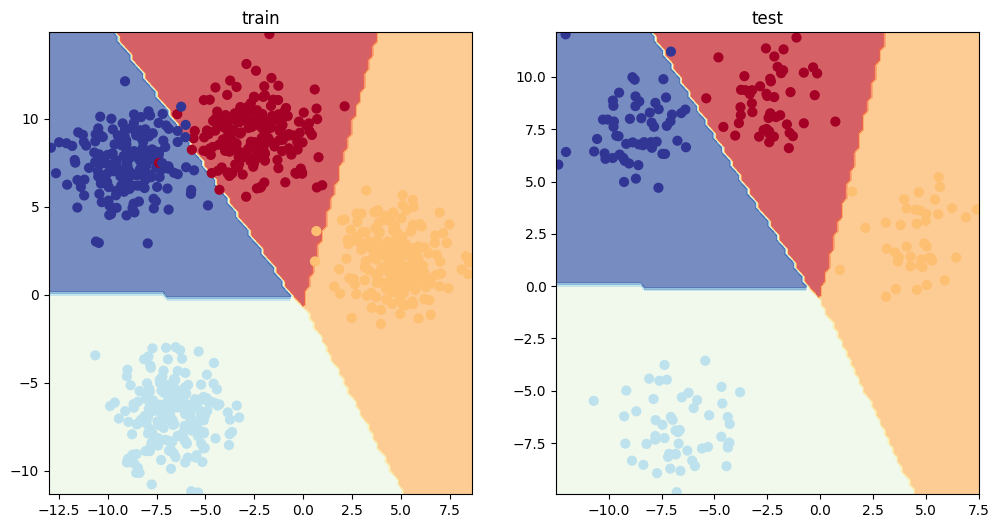

In [427]:
# plotting the decision boundary for train and test data.
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

In [428]:
# we can separate the clusters wihtout using Relu activatinon function aswell.

## 9. A few more classification metrices--(to evaluate our classification model)
* Accuracy: not for im-balanced data.
* Precision: im-balance dataset
* Recall
* F-score
* Confusion mtrix
* Classification report

In [429]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [430]:
from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task='multiclass',
                                     num_classes=NUM_CLASSES).to(device)

In [431]:
torchmetrics_accuracy(y_preds,y_blob_test)

tensor(0.9950)

* * * * * * * * * * * * * * **
 ** * * *** * * ** * *  * ** * * *
  ** * ** * *

## Exercises

## Task 1
* Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors.
* Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [432]:
# Device:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [433]:
# importing depedencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y  = make_moons(n_samples = 1000,
                  noise = 0.03,
                  random_state=42)


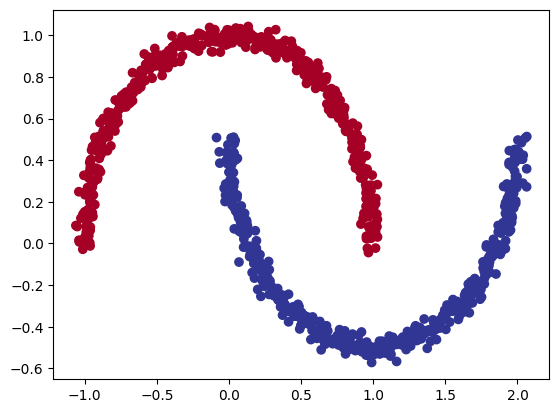

In [434]:
# plotting the two coordinates of X against y
plt.scatter(X[:,0],X[:,1], c= y, cmap = plt.cm.RdYlBu)

In [435]:
# 3: turning to tensors.
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [436]:
y.dtype,X.dtype

(torch.float32, torch.float32)

In [437]:
# 4. Train test split
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [438]:
X_train.shape,X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

## Task 2:
* Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [439]:
X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [440]:
# Model building
class Ex_Make_Moon(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    # layers;
    self.linear_stack_layer = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  # forward computation.
  def forward(self,x):
    return self.linear_stack_layer(x)

In [441]:
Ex_model = Ex_Make_Moon(input_features = 2, output_features = 1, hidden_units = 8).to(device)
Ex_model

Ex_Make_Moon(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

## Task 3:
* Setup a binary classification compatible loss function and optimizer to use when training the model.


In [442]:
# Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=Ex_model.parameters(),lr = 0.08)

## Task 4:
* Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [443]:
# Training loop:
epochs = 1000
# Put all data on target device:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  Ex_model.train()
  # forward pass
  y_logits = Ex_model(X_train).squeeze()
  y_labels = torch.round(torch.sigmoid(y_logits)) # logits->prob->lables.
  # loss and acc
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_labels,y_train)
  # zero grad
  optimizer.zero_grad()
  # backward
  loss.backward()
  # optimizer step;
  optimizer.step()

  ## TESTING.
  Ex_model.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = Ex_model(X_test).squeeze()
    test_labels = torch.round(torch.sigmoid(test_logits))
    # loss:
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_labels, y_test)

  ## Printing what's happening.
  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | loss: {loss:.4f} | acc: {acc:.2f}% | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")




Epoch: 0 | loss: 0.7120 | acc: 50.00% | test_loss: 0.7061 | test_acc: 50.00%
Epoch: 50 | loss: 0.6465 | acc: 81.88% | test_loss: 0.6486 | test_acc: 82.50%
Epoch: 100 | loss: 0.4590 | acc: 83.00% | test_loss: 0.4710 | test_acc: 82.00%
Epoch: 150 | loss: 0.3065 | acc: 85.75% | test_loss: 0.3185 | test_acc: 84.50%
Epoch: 200 | loss: 0.2581 | acc: 87.75% | test_loss: 0.2635 | test_acc: 88.50%
Epoch: 250 | loss: 0.2389 | acc: 88.75% | test_loss: 0.2396 | test_acc: 90.50%
Epoch: 300 | loss: 0.2286 | acc: 89.38% | test_loss: 0.2266 | test_acc: 90.50%
Epoch: 350 | loss: 0.2215 | acc: 89.62% | test_loss: 0.2181 | test_acc: 91.00%
Epoch: 400 | loss: 0.2146 | acc: 89.75% | test_loss: 0.2104 | test_acc: 91.00%
Epoch: 450 | loss: 0.2068 | acc: 90.00% | test_loss: 0.2020 | test_acc: 92.00%
Epoch: 500 | loss: 0.1975 | acc: 90.75% | test_loss: 0.1921 | test_acc: 92.00%
Epoch: 550 | loss: 0.1863 | acc: 91.50% | test_loss: 0.1806 | test_acc: 93.00%
Epoch: 600 | loss: 0.1728 | acc: 92.12% | test_loss: 0.

## Observations:
* Accuracy was not increasing after 80% `[lr=0.01,0.03]`, epoch = 100, noise = 0.05
* To increase accuracy, we changed the hyperparameters:`[lr = 0.08]`, epochs =1000, noise = 0.03.

## Task 5:
* Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

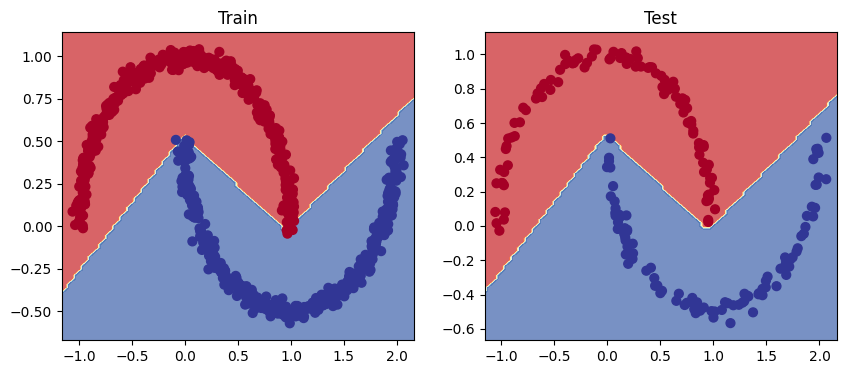

In [444]:
# visualize !!
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(Ex_model,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(Ex_model,X_test,y_test)

In [445]:
Ex_model

Ex_Make_Moon(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [446]:
# Making predictions.
Ex_model.eval()
with torch.inference_mode():
  y_test_logits = Ex_model(X_test)
y_preds = torch.round(torch.sigmoid(y_test_logits.to(device)))

In [447]:
from torchmetrics import Accuracy
acccc = Accuracy(task='binary', num_classes=2).to(device)
acccc(y_preds.squeeze(),y_test)

tensor(0.9950)

## Task 6:
* Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
* Feel free to reference the ML cheatsheet website for the formula.

In [448]:
x = torch.arange(-5,5,.4)

In [449]:
def Tanh(x):
  return ( torch.exp(x) - torch.exp(-x )) / (torch.exp(x)+torch.exp(-x))

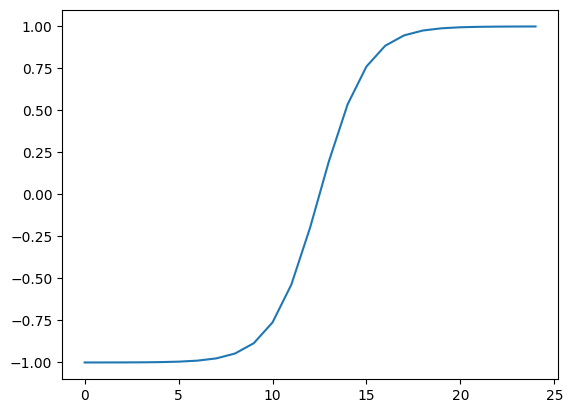

In [450]:
plt.plot(Tanh(x))

## Task 7:
* Create a multi-class dataset using the spirals data creation function from CS231.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

In [451]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

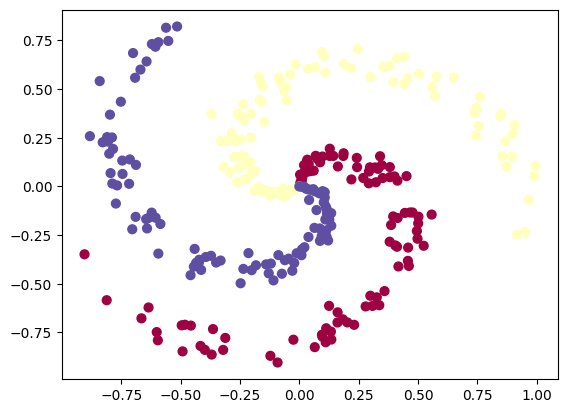

In [487]:

# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [488]:
# converting the data into tensors.
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [489]:
X.dtype,y.dtype

(torch.float32, torch.int64)

In [490]:
# model
class SpiralModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  # forward computations
  def forward(self,x):
    return self.linear_layer_stack(x)


In [491]:
spiral_model = SpiralModel(input_features = 2, output_features = 3, hidden_units = 8).to(device)
spiral_model

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [492]:
# loos and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= spiral_model.parameters(),lr = 0.02)

In [493]:
# train test split.
import torch
from sklearn.model_selection import train_test_split
X_train_spiral, X_test_spiral, y_train_spiral,y_test_spiral = train_test_split(X,y,test_size=0.2,random_state=42)

In [494]:
X.dtype

torch.float32

# Training and testing loop:

In [495]:
# putting all on the device:
X_train_spiral = X_train_spiral.to(device)
X_test_spiral = X_test_spiral.to(device)
y_train_spiral = y_train_spiral.to(device)
y_test_spiral = y_test_spiral.to(device)

In [496]:
y_train_spiral.dtype

torch.int64

In [497]:
# Training loop:
epochs = 300
for epoch in range(epochs):
  spiral_model.train()
  # forward pass
  y_logits = spiral_model(X_train_spiral)
  y_preds = torch.softmax(y_logits,dim = 1).argmax(dim = 1) # softmax activation function.
  # print(y_logits.dtype,y_preds.dtype)
  # loss function.
  loss = loss_fn(y_logits,y_train_spiral)
  acc = accuracy_fn(y_preds,y_train_spiral)
  # zero grad
  optimizer.zero_grad()
  # backward.
  loss.backward()
  # step step
  optimizer.step()

  ## Testing.
  spiral_model.eval()
  with torch.inference_mode():
    test_logits = spiral_model(X_test_spiral)
    test_labels = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # loss
    test_loss = loss_fn(test_logits, y_test_spiral)
    test_acc = accuracy_fn(test_labels,y_test_spiral)

  # printing whats' happening.
  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | loss: {loss:.4f}|acc: {acc:.2f}% | test_loss:{test_loss:.4f}|test_acc:{test_acc:.2f}%")


Epoch: 0 | loss: 1.1181|acc: 32.50% | test_loss:1.0864|test_acc:36.67%
Epoch: 20 | loss: 0.8711|acc: 57.08% | test_loss:0.8529|test_acc:50.00%
Epoch: 40 | loss: 0.6267|acc: 61.25% | test_loss:0.6137|test_acc:61.67%
Epoch: 60 | loss: 0.4900|acc: 74.17% | test_loss:0.4629|test_acc:71.67%
Epoch: 80 | loss: 0.3734|acc: 80.00% | test_loss:0.3480|test_acc:76.67%
Epoch: 100 | loss: 0.2736|acc: 87.08% | test_loss:0.2578|test_acc:88.33%
Epoch: 120 | loss: 0.2007|acc: 91.25% | test_loss:0.1884|test_acc:95.00%
Epoch: 140 | loss: 0.1578|acc: 94.17% | test_loss:0.1437|test_acc:96.67%
Epoch: 160 | loss: 0.1310|acc: 94.58% | test_loss:0.1111|test_acc:98.33%
Epoch: 180 | loss: 0.1136|acc: 95.83% | test_loss:0.0899|test_acc:98.33%
Epoch: 200 | loss: 0.0998|acc: 97.08% | test_loss:0.0734|test_acc:98.33%
Epoch: 220 | loss: 0.0824|acc: 97.50% | test_loss:0.0523|test_acc:98.33%
Epoch: 240 | loss: 0.0715|acc: 97.92% | test_loss:0.0411|test_acc:100.00%
Epoch: 260 | loss: 0.0637|acc: 98.75% | test_loss:0.0326

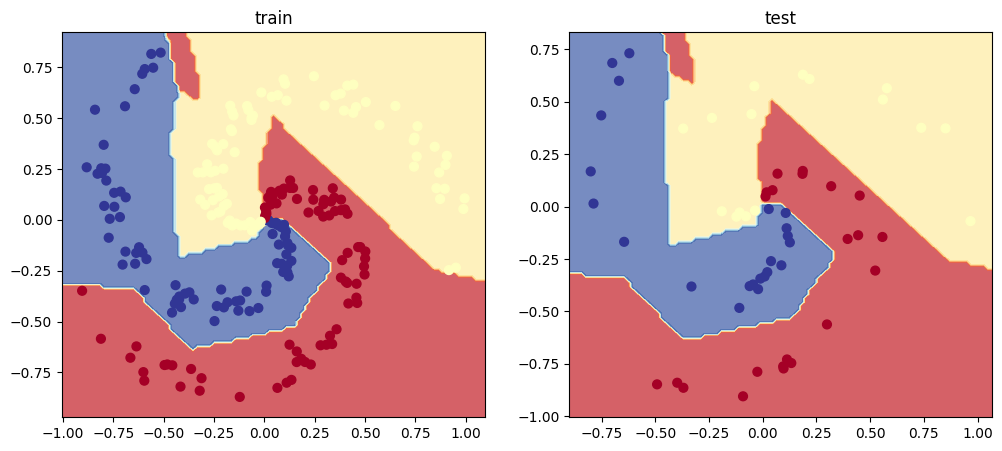

In [498]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(spiral_model,X_train_spiral,y_train_spiral)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(spiral_model,X_test_spiral,y_test_spiral)